In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt

In [2]:
input_fname = 'test.original.in'
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
emitStr = '0.64'
emit = float(emitStr)
y0 = 8

In [3]:
beam, lattice = impact.readInputFile(input_fname);
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
offset = y0*0.001
betx = 1.892632003629
alfx = 1.37638192047
emitxN = emit*1.0e-6

turns = int(1.0/np.sqrt(emitxN))
n_particles = 40000

beam.nCore_y = 8
beam.nCore_z = 4
beam.distribution.emitx = emitxN
beam.n_particles = n_particles

NL_t = 0.45
NL_c = 0.009

reading ImpactZ input file (test.original.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beamTmp = copy(beam)
beamTmp.distribution.betx = betx
beamTmp.distribution.alfx = alfx
beamTmp.distribution.distribution_type = 'IOTA_Waterbag'
beamTmp.distribution.NL_t = NL_t
beamTmp.distribution.NL_c = NL_c

In [5]:
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice.pop(0);
lattice[0].turns=turns
lattice[1].n_sckick = 100
testLat = [copy(lattice[0])]
testLat[0].turns=0

In [6]:
print(beamTmp.distribution)


 distribution_type: 'IOTA_Waterbag'
              mode: 'twiss'
              betz: 2324215873134.486 [degree/MeV]
              alfz: 0.0
             emitz: 6.89396745963425e-09 [degree-MeV]
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]
              betx: 1.892632003629 [m]
              alfx: 1.37638192047
             emitx: 6.4e-07 [m-rad]
            scalex: 1.0 [1.0]
           scalepx: 1.0 [1.0]
           offsetx: 0.0 [m]
          offsetpx: 0.0 [rad]
              bety: 2576.919407166738 [m]
              alfy: 0.0
             emity: 1.460965201818848e-07 [m-rad]
            scaley: 1.0 [1.0]
           scalepy: 1.0 [1.0]
           offsety: 0.0 [m]
          offsetpy: 0.0 [rad]
              NL_t: 0.45
              NL_c: 0.009


In [7]:
impact.writeInputFile(beamTmp,testLat)
impact.run(beamTmp)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

In [8]:
print(beamTmp.distribution)


 distribution_type: 'IOTA_Waterbag'
              mode: 'impactdist'
              NL_t: 0.45
              NL_c: 0.009
              betx: 1.892632003629 [m]
              alfx: 1.37638192047
             emitx: 6.4e-07 [m-rad]
            sigmaz: 2.2092772151898727
           lambdaz: 1.065789e-10
               muz: 0.0
            scalez: 1.0 [1.0]
           scalepz: 1.0 [1.0]
           offsetz: 0.0 [degree]
          offsetpz: 0.0 [MeV]


In [9]:
pDataInit = impact.readParticleData(-111110,ke,mass,freq)
pDataInit[:,2] = pDataInit[:,2] + offset

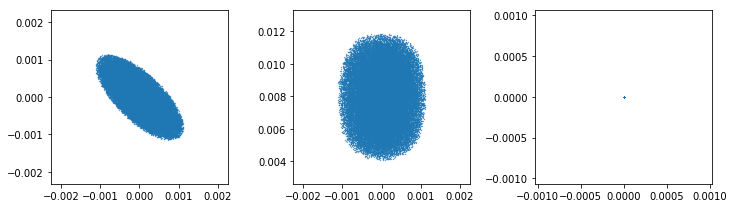

In [10]:
plt.figure(figsize=[10.3,3])
plt.subplot(1,3,1)
plt.scatter(pDataInit[:,0],pDataInit[:,1],s=0.1)
plt.subplot(1,3,2)
plt.scatter(pDataInit[:,0],pDataInit[:,2],s=0.1)
plt.subplot(1,3,3)
plt.scatter(pDataInit[:,4],pDataInit[:,5],s=0.1)
plt.tight_layout()

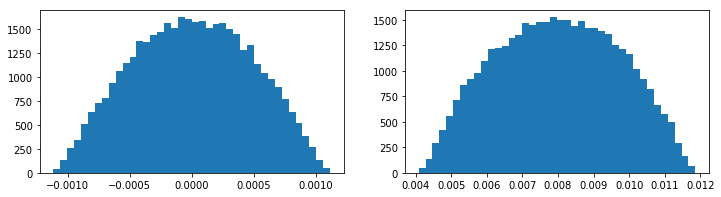

In [11]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(pDataInit[:,0],bins=40);
plt.subplot(1,2,2)
plt.hist(pDataInit[:,2],bins=40);

In [12]:
impact.writeParticleData(pDataInit,ke,mass,freq)
beam.distribution.distribution_type = 'ReadFile'
impact.writeInputFile(beam,lattice)
impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles


0

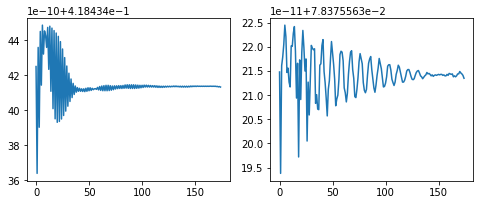

In [13]:
Inv = np.loadtxt('fort.81')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(Inv[:,1])
plt.subplot(1,2,2)
plt.plot(Inv[:,2])

In [14]:
L=0.0
for item in lattice:
    if 'length' in item.keys():
        L = L + item.length

Y=impact.readRMS('y')        
N = np.argwhere(np.mod(Y.s,L)==0.0)
N=N[:,0]

In [15]:
M=[]
z = 0.0
for i in range(len(N)):
    if z < Y.s[N[i]]:
        M.append(N[i-1])
        z = Y.s[N[i]]    
M=np.array(M)
print(Y.s[M[:10]])
print(Y.s[M[-1]])

[0.00E+00 2.00E+00 4.00E+00 6.00E+00 8.00E+00 1.00E+01 1.20E+01 1.40E+01
 1.60E+01 1.80E+01]
348.0


In [16]:
Z  = Y.s[M]
Yc = Y.centroid_y[M] 
Pc = Y.centroid_py[M]
Yc = Yc + 1j*(betx*Pc+alfx*Yc)
np.save('Yc.'+emitStr+'mm-mrad.'+str(y0)+'mm',Yc)

In [15]:
fort82=np.loadtxt('fort.82')
Y = fort82[:,3] + 1j*fort82[:,4]
np.save('Yc.mid.'+emitStr+'mm-mrad.'+str(y0)+'mm',Y)